In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from neurolib.models.multimodel import MultiModel
from tqdm import tqdm
from yasa import get_centered_indices

from aln_thalamus import ALNThalamusMiniNetwork
from plotting import plot_spectrum

DPI = 75
CMAP = "plasma"
plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")

SW = {"low_freq": 0.1, "high_freq": 2.5}
SP = {"low_freq": 11.0, "high_freq": 16.0}

In [2]:
def simulate(
    conn=2.0,
    ou_exc=4.1,
    ou_inh=1.8,
    ou_sigma=0.0,
    tauA=1000.0,
    glk=0.018,
    a=0.0,
    b=15.0,
):
    # all times in ms
    duration = 30000.0
    t_spin_up = 5000.0
    sampling_dt = 1.0
    dt = 0.01

    model = MultiModel(
        ALNThalamusMiniNetwork(
            np.array([[0.0, conn], [0.0, 0.0]]), np.array([[0.0, 13.0], [13.0, 0.0]])
        )
    )
    model.params["*g_LK"] = glk
    model.params["1ALNThlmNet.ALNNode_0.ALNMassEXC_0.a"] = a
    model.params["*b"] = b
    model.params["*tauA"] = tauA
    model.params["*EXC*mu"] = ou_exc
    model.params["*INH*mu"] = ou_inh
    model.params["*ALNMass*noise*sigma"] = ou_sigma
    model.params["duration"] = duration + t_spin_up
    model.params["dt"] = dt
    model.params["sampling_dt"] = sampling_dt
    model.params["backend"] = "numba"

    model.run()

    results_df = pd.DataFrame(
        {
            "ALN-EXC": model.r_mean_EXC[0, :] * 1000.0,
            "ALN-INH": model.r_mean_INH[0, :] * 1000.0,
            "I_adapt": model.I_A_EXC[0, :],
            "TCR": model.r_mean_EXC[1, :] * 1000.0,
        },
        index=model.t,
    )
    results_df.index.name = "time"
    return results_df

In [5]:
def plot_single(df, ax):
    (l1,) = ax.plot(df.index, df["ALN-INH"], color="C1", alpha=0.7)
    (l2,) = ax.plot(df.index, df["ALN-EXC"], color="C0")
    ax.set_ylim([-20, 130])
    sns.despine(trim=True, ax=ax)
    ax2 = ax.twinx()
    (l3,) = ax2.plot(df.index, df["TCR"], color="k", linewidth=2.5, alpha=0.5)
    ax2.set_ylim([-50, 1600.0])
    ax2.set_yticks([0.0, 400.0])
    sns.despine(trim=True, ax=ax2)
    return l1, l2, l3

100%|██████████| 30/30 [10:58<00:00, 21.95s/it]


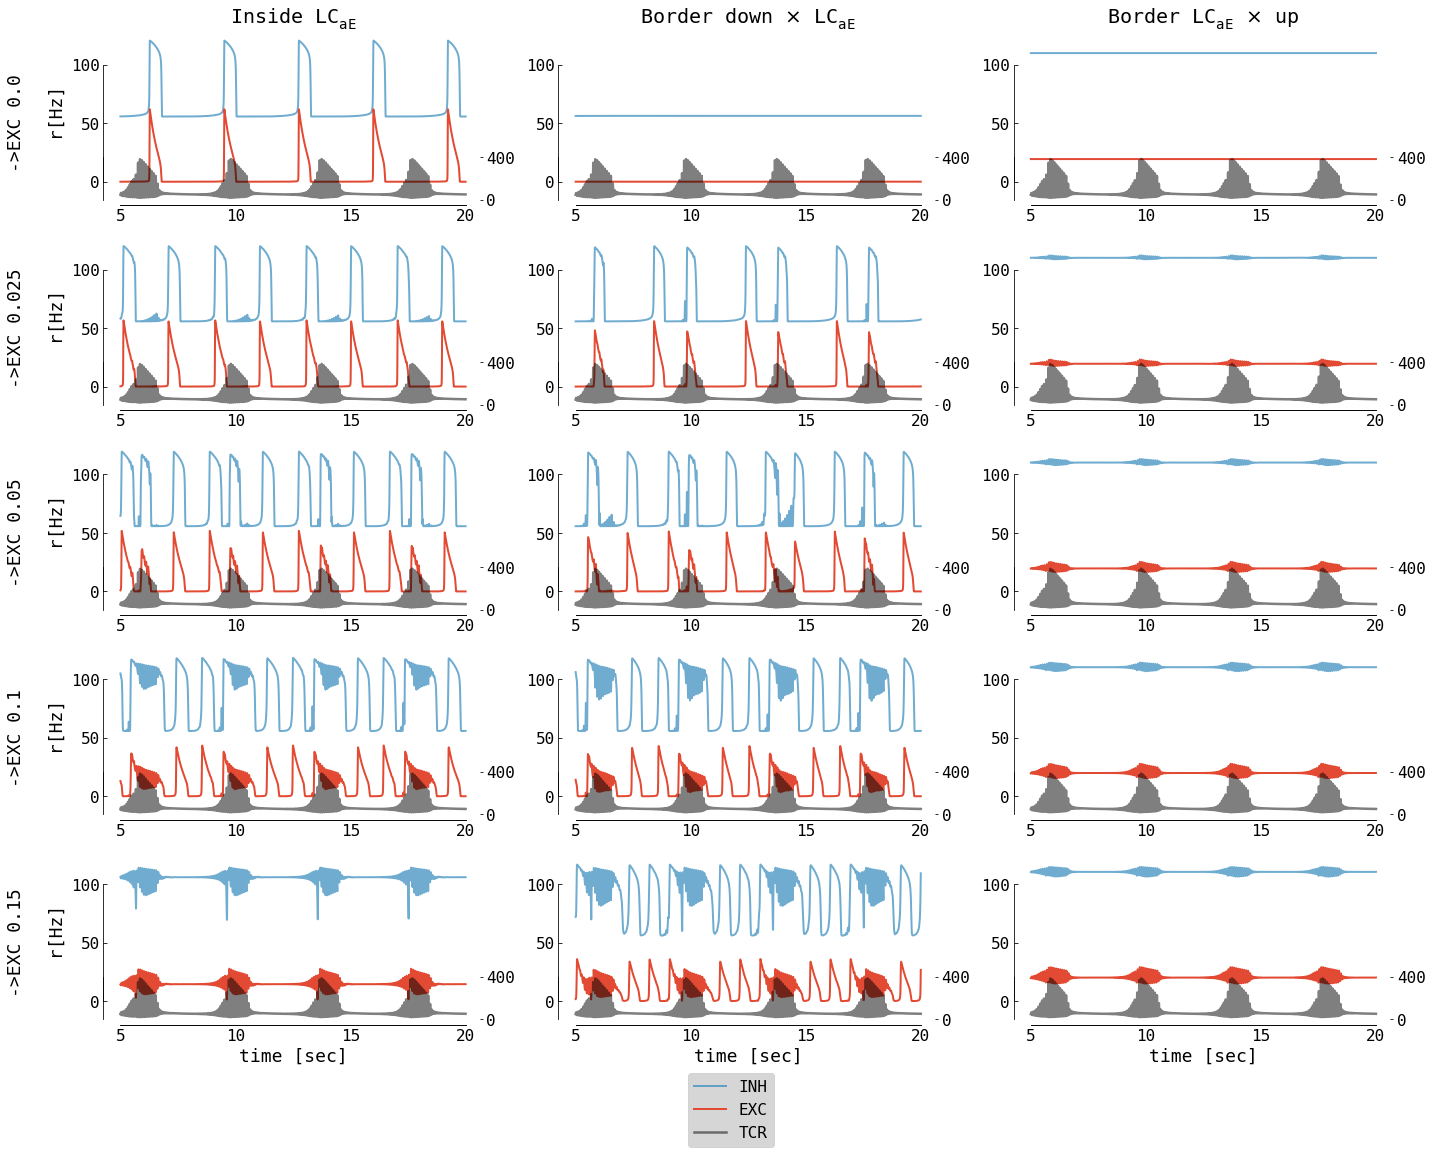

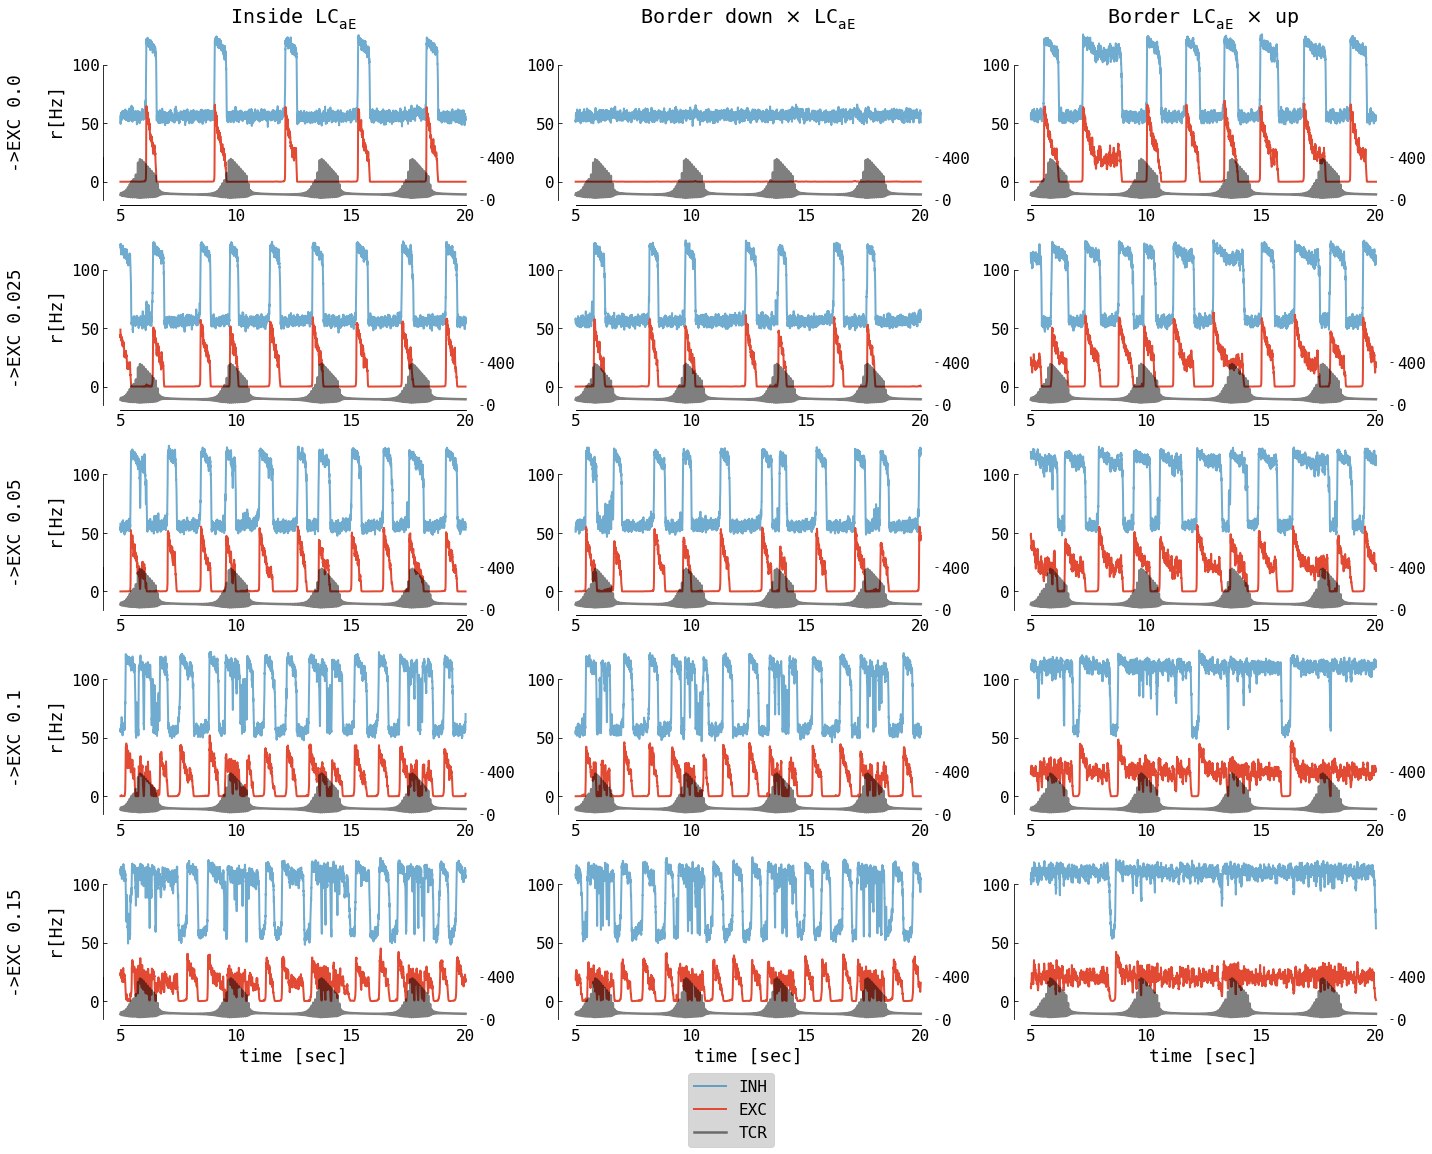

In [11]:
conns = [0.0, 0.025, 0.05, 0.1, 0.15]
noises = [0.0, 0.05]

params = [
    (3.2, 3.5, "Inside $\mathregular{{LC_{{aE}}}}$"),
    (3.07, 3.5, r"Border down $\times$ $\mathregular{{LC_{{aE}}}}$"),
    (3.65, 3.5, r"Border $\mathregular{{LC_{{aE}}}}$ $\times$ up"),
]

pbar = tqdm(total=len(conns) * len(noises) * len(params))

for noise in noises:
    fig, axs = plt.subplots(
        nrows=len(conns),
        ncols=len(params),
        figsize=(20, 3 * len(conns)),
        squeeze=False,
    )
    for j, (exc_inp, inh_inp, plot_name) in enumerate(params):
        for i, conn in enumerate(conns):
            ax = axs[i, j]
            df = simulate(
                conn=conn,
                ou_exc=exc_inp,
                ou_inh=inh_inp,
                ou_sigma=noise,
                tauA=1000.0,
                glk=0.031,
                a=0.0,
                b=15.0,
            )
            l1, l2, l3 = plot_single(df.loc[5:20], ax=ax)
            if i == (len(conns) - 1):
                ax.set_xlabel("time [sec]")
            if j == 0:
                ax.set_ylabel(f"->EXC {conn} \n\n r[Hz]")
            pbar.update(1)
        axs[0, j].set_title(plot_name)

    plt.tight_layout()
    fig.legend(
        (l1, l2, l3),
        ("INH", "EXC", "TCR"),
        loc="upper center",
        bbox_to_anchor=(0.51, 0.01),
        bbox_transform=fig.transFigure,
    )
    # to PDF due transparency
    plt.savefig(
        f"../figs/aln_rec_spindle_{noise}.pdf",
        transparent=True,
        bbox_inches="tight",
    )
    
pbar.close()